Here, you develop the 

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh_min = 64
refRatio = 2
CFL = 1 # np.sqrt(0.5)
nt = 10
x_0 = 0.
x_1 = 0.5
Hans = False

deriv = 'CD'
RK = 4
order = 2

L = 1.
locs = [x_1]
epsilons = [1, 0.5]# 11.68]
mus = [1, 0.5]#0.99837]

In [3]:
directoryString = '/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/'
valueFile = 'HansOutput.txt'
valueString = directoryString + valueFile
valueData = [x.strip() for x in open(valueString).readlines()]
print(valueData[1:])
print('')
HansX = []
HansXShift = []
HansProp = []

for val in valueData[1:]:
    #print(val)
    values = val.split(',')
    HansX.append(float(values[0]))
    HansXShift.append(float(values[1]))
    HansProp.append(float(values[2]))
print(HansX)
print(HansProp)
print('')

['0.0078125,-0.2265625,7.83266826963429e-67', '0.0234375,-0.2109375,7.73343642958576e-71', '0.0390625,-0.1953125,5.82137247514978e-75', '0.0546875,-0.1796875,3.34093740032327e-79', '0.0703125,-0.1640625,1.4618451472085e-83', '0.0859375,-0.1484375,4.87668253360957e-88', '0.1015625,-0.1328125,1.24033123462941e-92', '0.1171875,-0.1171875,2.40514330767287e-97', '0.1328125,-0.1015625,3.55577537790105e-102', '0.1484375,-0.0859375,4.00790815014971e-107', '0.1640625,-0.0703125,3.44422316988107e-112', '0.1796875,-0.0546875,2.25660158964488e-117', '0.1953125,-0.0390625,1.12721971888211e-122', '0.2109375,-0.0234375,4.29291556930637e-128', '0.2265625,-0.0078125,1.24648253759764e-133', '0.2421875,0.0078125,7.04828723161943e-15', '0.2578125,0.0234375,4.12318066718959e-13', '0.2734375,0.0390625,1.83895548949727e-11', '0.2890625,0.0546875,6.25316879919784e-10', '0.3046875,0.0703125,1.6211349501819e-08', '0.3203125,0.0859375,3.20426382983086e-07', '0.3359375,0.1015625,4.82866913276568e-06', '0.3515625,

In [4]:
omegaAMR = BT.Grid(nh_min)
finehalf = list(np.arange(int(nh_min / refRatio)))# + int(nh / refRatio))
omegaAMR.AddPatch(refRatio, finehalf)
degFreed = omegaAMR.degFreed
nh_max = omegaAMR.nh_max

omegaF = BT.Grid(nh_max)
omegaC = BT.Grid(nh_min)

In [5]:

physicsAMR = BT.PhysProps(omegaAMR, epsilons, mus, locs, L)
cVecAMR = physicsAMR.cVec
cMatAMR = physicsAMR.cMat
csAMR = physicsAMR.cs

physicsC = BT.PhysProps(omegaC, epsilons, mus, locs, L)
cVecC = physicsC.cVec
cMatC = physicsC.cMat
csC = physicsC.cs

physicsF = BT.PhysProps(omegaF, epsilons, mus, locs, L)
cVecF = physicsF.cVec
cMatF = physicsF.cMat
csF = physicsF.cs

In [6]:
# c = ConvertParams(permitivity, permeability, L)
t, nt = ST.CalcTime(omegaC, CFL, csAMR[0], nt = nt) # CHANGE BACK TO OMEGAAMR!!!
sigma, mu = WFT.GaussParams(x_0, x_1)
wavesAMR = WT.MakeWaves(omegaAMR)
nullspace = OT.FindNullspace(omegaAMR, wavesAMR, Hans = Hans)
restrictOp = GTT.CoarsenOp(omegaAMR)

wavesF = WT.MakeWaves(omegaF)
wavesC = WT.MakeWaves(omegaC)

derivMat = TT.ExactSpatOp(omegaAMR)
spatOp = -cMatF @ derivMat
timePropOp = LA2.expm(t * spatOp)

derivMatC = TT.ExactSpatOp(omegaC)
spatOpC = -cMatC @ derivMatC
timePropOpC = LA2.expm(t * spatOpC)
sigma = 0.03

print(t)

You are using ExactSpatOp in TestTools module!
You are using ExactSpatOp in TestTools module!
0.15625


In [7]:
# wavesAMR = OT.Block(wavesAMR, var = 2)
# nullspace = OT.Block(nullspace, var = 2)
# restrictOp = OT.Block(restrictOp, var = 2)
# wavesC = OT.Block(wavesC, var = 2)
# wavesF = OT.Block(wavesF, var = 2)

opC = -cMatC @ OT.SpaceDeriv(omegaC, order, diff)
opF = -cMatF @ OT.SpaceDeriv(omegaF, order, diff)
opAMR = -cMatAMR @ OT.SpaceDeriv(omegaAMR, order, diff)

In [8]:
# For Gaussian:
waveInitC = WFT.Gauss(omegaC, physicsC, sigma, mu)
# waveInitC = np.append(waveInitC, waveInitC)
waveInitF = WFT.Gauss(omegaF, physicsF, sigma, mu)
# waveInitF = np.append(waveInitF, waveInitF)

print(np.shape(wavesC))
print(np.shape(waveInitC))
FCoefsC = FFTT.FourierCoefs(wavesC, waveInitC)
FCoefsF = FFTT.FourierCoefs(wavesF, waveInitF)
FCoefsC1 = np.asarray(np.append(FCoefsC, FCoefsC))

# Find initial waveform on coarse, fine, and AMR grids.
# waveInitC = wavesC @ FCoefsC
# waveInitF = wavesF @ FCoefsF
waveInitAMR = restrictOp @ waveInitF

# Find Fourier coefficients for initial condition on AMR grid.
FCoefsAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, waveInitAMR)
# print('initial Coarse:')
# print(np.round(FCoefsC, 14))
# print('initial Fine:')
# print(np.round(FCoefsF, 14))
# print('initial AMR:')
# print(np.round(FCoefsAMR, 14))
# print('')

wavePropC = WFT.Gauss(omegaC, physicsC, sigma, mu, t = t) # timePropOpC @ FCoefsC
wavePropF = WFT.Gauss(omegaF, physicsF, sigma, mu, t = t)

# Find propagated coeficients on coarse and fine grid.
FCoefsPropC = FFTT.FourierCoefs(wavesC, wavePropC) # timePropOpC @ FCoefsC
FCoefsPropF = FFTT.FourierCoefs(wavesF, wavePropF) # timePropOp @ FCoefsF
FCoefsPropC1 = np.asarray(np.append(FCoefsPropC, FCoefsPropC))

FCoefsPropC2 = timePropOpC @ FCoefsC
FCoefsPropF2 = timePropOp @ FCoefsF

# Find propagated waveform on AMR grid.
wavePropAMR = restrictOp @ wavesF @ FCoefsPropF

# Find propagated coefficients on AMR grid.
FCoefsPropAMR = FFTT.FourierCoefs(wavesAMR @ nullspace, wavePropAMR)

# TEST FOR EXACT GAUSSIAN AT NEW LOCATION.

print(FCoefsPropC)
print(FCoefsPropF)
print(np.round(FCoefsPropAMR, 14))

# Find theoretical propagated coefficients on coarse, fine, and AMR grid. (THIS CAN ONLY BE USED IF MATERIAL IS UNIFORM!)
# FCoefsPropCTh = FFTT.PropRestrictWaves(omegaC, waveInitC, c * t)
# FCoefsPropFTh = FFTT.PropRestrictWaves(omegaF, waveInitF, c * t)
# FCoefsPropAMRTh = FFTT.PropRestrictWaves(omega, waveInitF, c * t)

solverCoefsC = ST.RungeKutta(omegaC, physicsC, wavesC, waveInitC, nt, CFL, RK, op = opC) # TimeIntegratorFunc(omegaC, wavesC, waveInitC, nt, cMatC, CFL, DiffFunc)
solverCoefsF = ST.RungeKutta(omegaF, physicsF, wavesF, waveInitF, nt, CFL, RK, op = opF) # TimeIntegratorFunc(omegaF, wavesF, waveInitF, nt, cMatF, CFL, DiffFunc)
solverCoefsAMR = ST.RungeKutta(omegaAMR, physicsAMR, wavesAMR @ nullspace, waveInitAMR, nt, CFL, RK, op = opAMR) # TimeIntegratorFunc(omegaAMR, wavesAMR @ nullspace, waveInitAMR, nt, cMat, CFL, DiffFunc, order = order)
solverCoefsC1 = np.asarray(np.append(solverCoefsC, solverCoefsC))

# print('')
# print(np.round(FCoefsPropCTh, 14))
# print(np.round(FCoefsPropFTh, 14))
# print(np.round(FCoefsPropAMRTh, 14))


allCoefsC = PT.Load(FCoefsC, FCoefsPropC)#, solverCoefsC)#, FCoefsPropCTh)
allCoefsF = PT.Load(FCoefsF, FCoefsPropF)#, solverCoefsF)#, FCoefsPropFTh)
allCoefsAMR = nullspace @ PT.Load(FCoefsAMR, FCoefsPropAMR)#, solverCoefsAMR)#, FCoefsPropAMRTh)


print('')
print(FCoefsPropC)
print(FCoefsPropC2)
print('')


labels = ['Initial Wave', 'Method of Characteristics Propagated Wave']#, 'RK Propagated Wave']#, 'Rotation Matrix Propagated Wave']
title = 'MaterialInterface' + str(nt)



(64, 64)
(64,)
[ 7.52657019e-02  8.20646071e-02 -1.22980535e-01 -1.29378309e-01  5.37313537e-02  1.25655501e-01  2.48915416e-02 -7.99651208e-02 -7.99341317e-02  1.87391353e-02  9.45225152e-02  3.04476204e-02 -7.32289947e-02 -5.24528392e-02  3.49325834e-02  4.83342766e-02  4.23421949e-05 -2.97446545e-02 -1.98470283e-02  9.82262947e-03  2.35332942e-02  3.34080603e-03 -1.72001093e-02 -8.16278252e-03  8.23974502e-03  7.25909765e-03 -1.45558430e-03 -4.20973113e-03 -1.77572036e-03  1.47746500e-03  2.30620559e-03  5.23680074e-05 -1.60427516e-03 -5.40182021e-04  7.50014075e-04  4.83393086e-04 -1.96244855e-04 -2.81942821e-04 -3.35317200e-05  1.24002474e-04  7.26081756e-05 -4.55005835e-05 -4.40830212e-05  2.07383170e-05  1.18750981e-05 -1.87992852e-05  6.04671071e-06  2.19023816e-05 -1.20236071e-05 -2.38889574e-05  1.21826754e-05  2.41834852e-05 -1.05406733e-05 -2.36564931e-05  8.69914034e-06  2.30218617e-05 -6.98904867e-06 -2.26021497e-05  5.34290343e-06  2.24912112e-05 -3.66022487e-06 -2.27062

fX is not []
Are you *sure* your labels are ordered correctly?
This image has been saved under /Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/MaterialInterface10.
[ 7.52657019e-02  8.20646071e-02 -1.22980535e-01 -1.29378309e-01  5.37313537e-02  1.25655501e-01  2.48915416e-02 -7.99651208e-02 -7.99341317e-02  1.87391353e-02  9.45225152e-02  3.04476204e-02 -7.32289947e-02 -5.24528392e-02  3.49325834e-02  4.83342766e-02  4.23421949e-05 -2.97446545e-02 -1.98470283e-02  9.82262947e-03  2.35332942e-02  3.34080603e-03 -1.72001093e-02 -8.16278252e-03  8.23974502e-03  7.25909765e-03 -1.45558430e-03 -4.20973113e-03 -1.77572036e-03  1.47746500e-03  2.30620559e-03  5.23680074e-05 -1.60427516e-03 -5.40182021e-04  7.50014075e-04  4.83393086e-04 -1.96244855e-04 -2.81942821e-04 -3.35317200e-05  1.24002474e-04  7.26081756e-05 -4.55005835e-05 -4.40830212e-05  2.07383170e-05  1.18750981e-05 -1.87992852e-05  6.04671071e-06  2.19023816e-05 -1.20236071e-05 -2.38889574e-05  1.21826754e-05  2.41834852e-

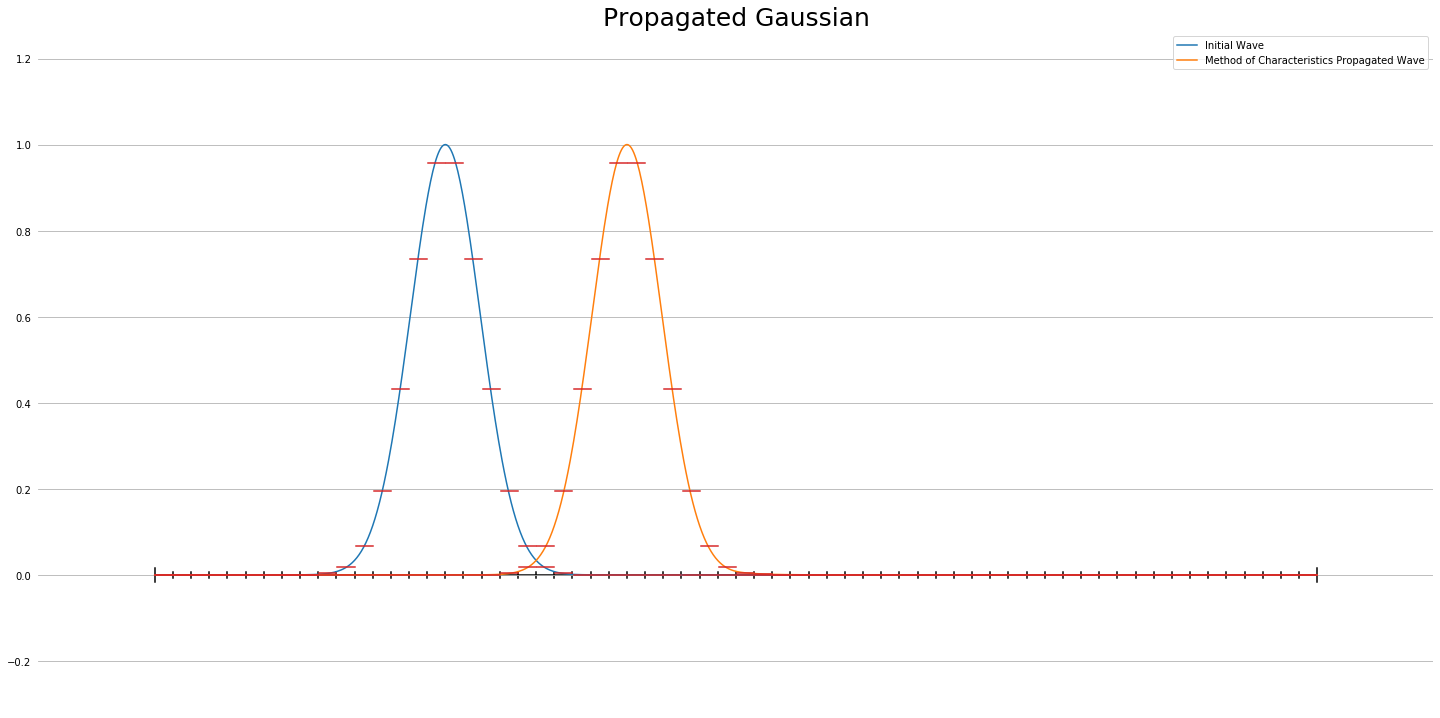

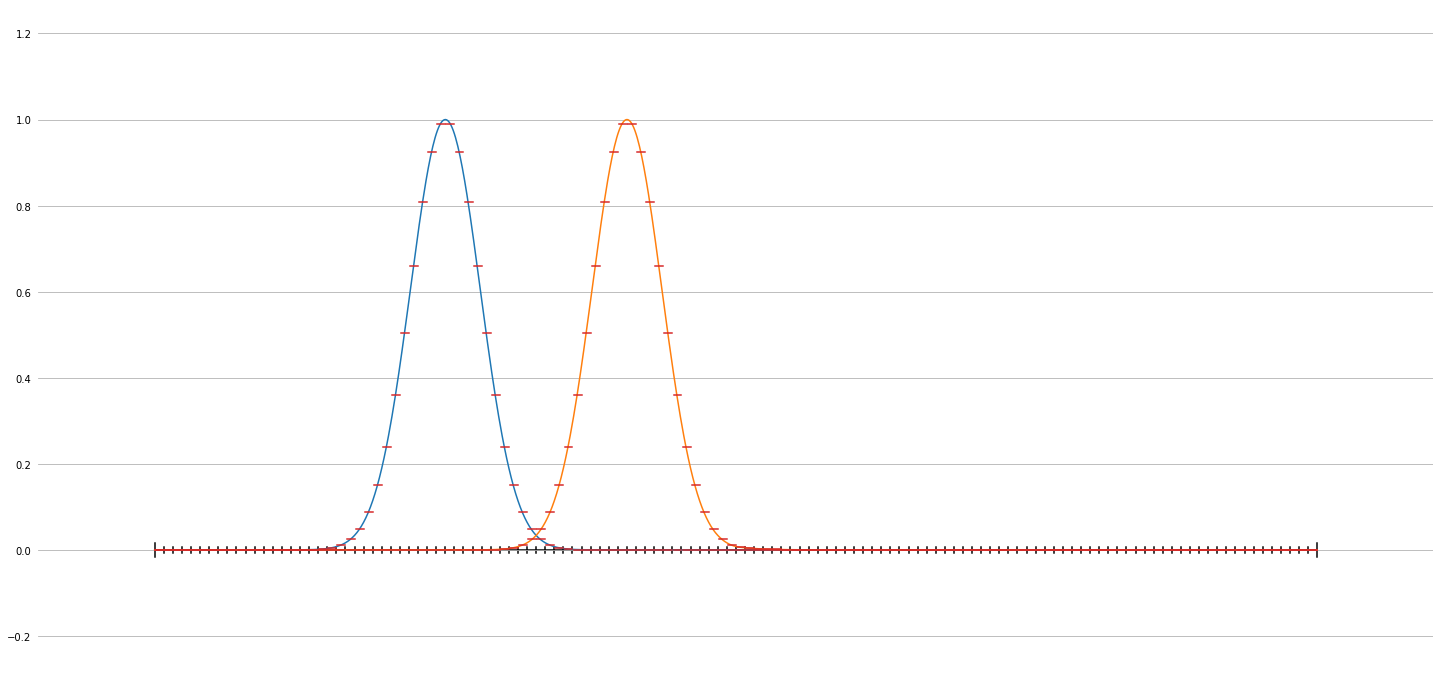

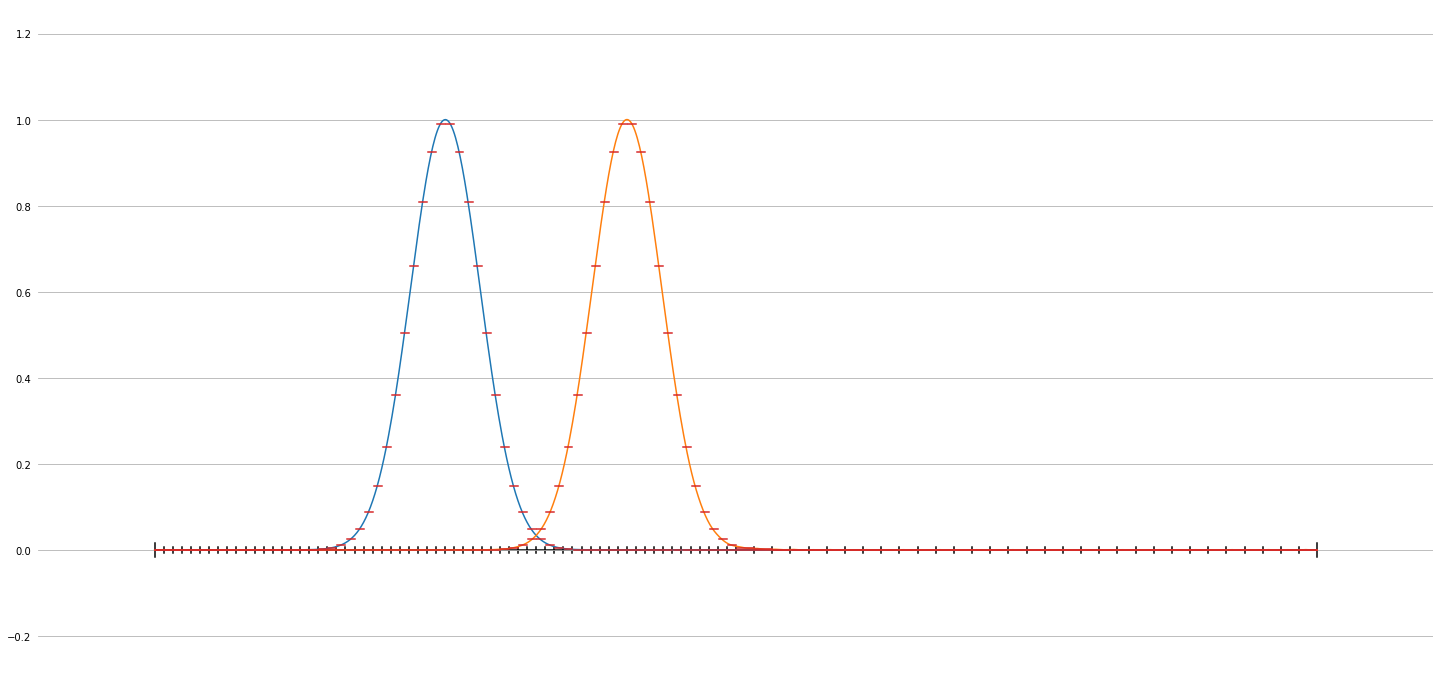

In [9]:
PT.PlotMixedWave(omegaC, waves = wavesC, FCoefs = allCoefsC, rescale = 5, yGrid = True, labels = labels, title = 'Propagated Gaussian', saveName = title, dpi = 300)
print(FCoefsPropC)
print('')
PT.PlotMixedWave(omegaF, waves = wavesF, FCoefs = allCoefsF, rescale = 5, yGrid = True)#, labels = labels, title = 'Fine-Grid Mode Propagation', saveName = 'Fine', dpi = 300)
PT.PlotMixedWave(omegaAMR, waves = wavesAMR, FCoefs = allCoefsAMR, rescale = 5, yGrid = True)#, labels = labels, title = 'AMR-Grid Mode Propagation', saveName = 'AMRHansMethod', dpi = 300)


In [10]:
# Notes for Hans:
#
# If the resolution is too low, there isn't sufficient high-frequency content to represent the gaussian.
# Sparse function needs to be developed for upwind and center-diffference of arbitrary-order polynomial interpolation.
# I see that I can't use the rotation matrix to propagate the matrices. I'm pretty sure that my Fourier-propagated logic is wrong, though.
# 2nd-order polynomial interp is working BETTER THAN 3rd-order for RK4 center diff.
# How do I employ Fourier transforms on Maxwell's Equations?


In [11]:
# Notes for Sasha:
#
# Make residuals test of Gaussian (first unpropagated, then propagated) to assess its validity.


In [12]:
# dx = L / nh_min
# dt = CFL*dx / 1.
# #nstep = .1*L /(1.*dt)
# t = dt * nt

In [13]:
locs = physicsC.locs
print(locs[0])

0.5


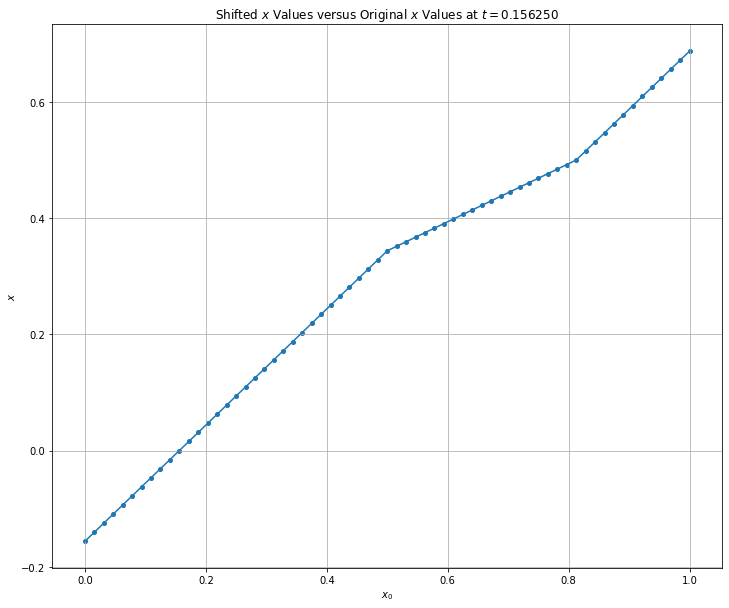

In [14]:
x_0vec = omegaC.xNode
xShift = WFT.ShiftX(omegaC, physicsC, t)
fig, ax = plt.subplots(figsize = [12, 10])
plt.plot(x_0vec, xShift)
plt.scatter(x_0vec, xShift, s = 16)
plt.title(r'Shifted $x$ Values versus Original $x$ Values at $t = %f$' %t)
plt.xlabel(r'$x_{0}$')
plt.ylabel(r'$x$')
ax.grid(True, zorder = 0)
saveName = '/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/xvsx_0_' + str(nt)
# fig.savefig(saveName + '.png', bbox_inches = 'tight')
plt.show()

In [15]:
print(physicsC.cs[1] * t)

0.3125


In [16]:
A = np.arange(10)
print(A)
print(A[:-1])

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8]
